#  MCMIPF + Ground Tabular

- Image-only CNN-LSTM on MCMIPF
- Fusion: MCMIPF + tabular sequences

In [1]:
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

2025-11-27 16:26:41.573278: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 16:26:41.579027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764278801.585127 2014481 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764278801.587157 2014481 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-27 16:26:41.594513: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Config

In [2]:
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

gpus = tf.config.list_physical_devices("GPU")
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass
print("TF GPUs:", gpus)

ROOT       = Path("..").resolve()
DATA_DIR   = ROOT / "data_processed"
GOES_DIR   = Path("/mnt/SOLARLAB/E_Ladino/Repo/irradiance-fusion-forecast/data_processed/GOES_v2")
MCMIPF_DIR = GOES_DIR / "MCMIPF"

OUT_DIR = ROOT / "outputs_mcmipf_ground"
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = OUT_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_PQ = DATA_DIR / "ground_train_h6.parquet"
VAL_PQ   = DATA_DIR / "ground_val_h6.parquet"
TEST_PQ  = DATA_DIR / "ground_test_h6.parquet"
TARGET   = "y_ghi_h6"

# Base hyperparameters (overridden by FAST_MODE if enabled)
IMG_SIZE    = 32          # spatial resolution (256 → IMG_SIZE)
SEQ_LEN     = 12          # temporal context (steps of 10 min)
PATIENCE    = 10          # early stopping patience
MAX_EPOCHS  = 60          # max epochs for both models
SUBSAMPLE   = 1           # temporal subsampling factor
SEL_CHANNELS = (1, 2, 3, 5, 7, 10, 13, 15)  # ABI channels

# Fast mode to control runtime when running full time range
FAST_MODE = True

if FAST_MODE:
    # Lighter temporal and training configuration, keeping safe spatial factor (256 % IMG_SIZE == 0)
    SEQ_LEN    = 6
    PATIENCE   = 5
    MAX_EPOCHS = 25
    SUBSAMPLE  = 3
    SEL_CHANNELS = (1, 2, 13, 15)  # reduced subset of channels
    # IMG_SIZE kept at 32 to preserve exact 256→32 downsampling
    
print("DATA_DIR:", DATA_DIR.resolve())
print("GOES_DIR:", GOES_DIR.resolve())
print(f"FAST_MODE={FAST_MODE} | SUBSAMPLE={SUBSAMPLE} | SEQ_LEN={SEQ_LEN} | "
      f"IMG_SIZE={IMG_SIZE} | channels={SEL_CHANNELS}")

TF GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
DATA_DIR: /mnt/SOLARLAB/E_Ladino/Repo/irradiance-fusion-forecast/data_processed
GOES_DIR: /mnt/SOLARLAB/E_Ladino/Repo/irradiance-fusion-forecast/data_processed/GOES_v2
FAST_MODE=True | SUBSAMPLE=3 | SEQ_LEN=6 | IMG_SIZE=32 | channels=(1, 2, 13, 15)


## Helpers

In [3]:
def _rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

def skill(y_true, y_pred, y_base):
    return 1.0 - (_rmse(y_true, y_pred) / (_rmse(y_true, y_base) + 1e-6))

def build_baseline(test_df, ytr, target_col):
    """Simple persistence-like baseline, with a fallback to the training median."""
    if target_col.startswith("y_ghi"):
        candidates = ["ghi_qc", "ghi_sg_definitive", "ghi_qc_lag1"]
    else:
        candidates = ["k_ghi", "k_raw", "k_ghi_lag1", "k_raw_lag1"]

    base_src = None
    for c in candidates:
        if c in test_df.columns:
            base_src = test_df[c]
            break
    if base_src is None:
        base_src = pd.Series(np.nanmedian(ytr), index=test_df.index)
        print("WARNING: degenerate baseline (median).")
    return base_src.to_numpy()

def hourly_skill_df(y_true, y_pred, y_base, idx):
    """Skill vs persistence by hour of day on the test set."""
    df = pd.DataFrame({
        "time": idx,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_base": y_base,
    }).set_index("time")
    df["hour"] = df.index.hour

    rows = []
    for h in range(24):
        sub = df[df["hour"] == h]
        if len(sub) < 10:
            continue
        rmse_m = _rmse(sub["y_true"], sub["y_pred"])
        rmse_b = _rmse(sub["y_true"], sub["y_base"])
        skl = 1.0 - rmse_m / (rmse_b + 1e-6)
        rows.append((h, rmse_m, rmse_b, skl))

    if not rows:
        return pd.DataFrame(columns=["rmse_model", "rmse_base", "skill"])

    res = pd.DataFrame(rows, columns=["hour", "rmse_model", "rmse_base", "skill"]).set_index("hour")
    return res

### Sequence

In [4]:
def build_tab_seq_with_idx(X_2d, y_1d, idx, L):
    """Build (L, F) tabular sequences aligned with index."""
    N, F = X_2d.shape
    xs, ys, idx_list = [], [], []
    for i in range(L-1, N):
        block = X_2d[i-L+1:i+1]
        if np.isnan(block).any():
            continue
        xs.append(block)
        ys.append(y_1d[i])
        idx_list.append(idx[i])
    if not xs:
        return (
            np.zeros((0, L, F), dtype="float32"),
            np.zeros((0,), dtype="float32"),
            pd.DatetimeIndex([])
        )
    return (
        np.asarray(xs, dtype="float32"),
        np.asarray(ys, dtype="float32"),
        pd.DatetimeIndex(idx_list)
    )

def build_img_seq_with_idx(imgs_4d, y_1d, idx, L):
    """Build (L, H, W, C) image sequences aligned with index."""
    N = imgs_4d.shape[0]
    H, W, C = imgs_4d.shape[1:]
    xs, ys, idx_list = [], [], []
    for i in range(L-1, N):
        block = imgs_4d[i-L+1:i+1]
        if np.isnan(block).any():
            continue
        xs.append(block)
        ys.append(y_1d[i])
        idx_list.append(idx[i])
    if not xs:
        return (
            np.zeros((0, L, H, W, C), dtype="float32"),
            np.zeros((0,), dtype="float32"),
            pd.DatetimeIndex([])
        )
    return (
        np.asarray(xs, dtype="float32"),
        np.asarray(ys, dtype="float32"),
        pd.DatetimeIndex(idx_list)
    )

def build_fusion_seq_with_idx(X_2d, imgs_4d, y_1d, idx, L):
    """Build aligned tabular + image sequences for fusion models."""
    N, F = X_2d.shape
    H, W, C = imgs_4d.shape[1:]
    xs_tab, xs_img, ys, idx_list = [], [], [], []
    for i in range(L-1, N):
        block_tab = X_2d[i-L+1:i+1]
        block_img = imgs_4d[i-L+1:i+1]
        if np.isnan(block_tab).any() or np.isnan(block_img).any():
            continue
        xs_tab.append(block_tab)
        xs_img.append(block_img)
        ys.append(y_1d[i])
        idx_list.append(idx[i])
    if not xs_tab:
        return (
            np.zeros((0, L, F), dtype="float32"),
            np.zeros((0, L, H, W, C), dtype="float32"),
            np.zeros((0,), dtype="float32"),
            pd.DatetimeIndex([])
        )
    return (
        np.asarray(xs_tab, dtype="float32"),
        np.asarray(xs_img, dtype="float32"),
        np.asarray(ys, dtype="float32"),
        pd.DatetimeIndex(idx_list)
    )

### Plots

In [5]:
def plot_ts_clip(idx, y_true, y_pred, y_base, name, out_dir: Path, N=400):
    """Test time series clip: truth vs model vs baseline."""
    N = min(N, len(y_true))
    plt.figure(figsize=(12, 3.6))
    plt.plot(idx[:N], y_true[:N], label="truth", lw=1.4)
    plt.plot(idx[:N], y_pred[:N], label=name, lw=1.1)
    if y_base is not None:
        plt.plot(idx[:N], y_base[:N], label="baseline", lw=1.0, alpha=0.7)
    plt.title(f"Test — Truth vs {name} vs Baseline")
    plt.ylabel("GHI (W/m²)")
    plt.xlabel("Time")
    plt.grid(True, ls="--", alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    fname = out_dir / f"{name}_ts_test.png"
    plt.savefig(fname, dpi=140)
    plt.show()
    return fname

def plot_scatter(y_true, y_pred, name, out_dir: Path):
    """Scatter plot: y_true vs y_pred with 1:1 line and metrics."""
    rmse = _rmse(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    lim_min = float(min(np.min(y_true), np.min(y_pred)))
    lim_max = float(max(np.max(y_true), np.max(y_pred)))
    plt.figure(figsize=(4.8, 4.8))
    plt.scatter(y_true, y_pred, s=10, alpha=0.5)
    plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', lw=1.0)
    plt.xlabel("Actual GHI (W/m²)")
    plt.ylabel("Predicted GHI (W/m²)")
    plt.title(f"{name} — Actual vs Predicted\nRMSE={rmse:.3f} MAE={mae:.3f} R2={r2:.3f}")
    plt.grid(True, ls="--", alpha=0.3)
    plt.tight_layout()
    fname = out_dir / f"{name}_scatter.png"
    plt.savefig(fname, dpi=140)
    plt.show()
    return fname

def plot_residuals(y_true, y_pred, name, out_dir: Path):
    """Histogram of residuals (y_pred - y_true)."""
    resid = y_pred - y_true
    plt.figure(figsize=(6, 3.2))
    plt.hist(resid, bins=50, alpha=0.85)
    plt.axvline(0, color='r', ls='--', lw=1)
    plt.title(f"{name} — Residuals (mean={np.mean(resid):.3f})")
    plt.xlabel("Residual (W/m²)")
    plt.ylabel("Frequency")
    plt.grid(True, ls="--", alpha=0.3)
    plt.tight_layout()
    fname = out_dir / f"{name}_residuals.png"
    plt.savefig(fname, dpi=140)
    plt.show()
    return fname

def plot_hourly_skill(sk_df, name, out_dir: Path):
    """Skill vs persistence by hour of day."""
    if sk_df.empty:
        return None
    plt.figure(figsize=(7, 3.5))
    plt.plot(sk_df.index, sk_df["skill"], marker="o")
    plt.axhline(0.0, ls="--", lw=1, color="k")
    plt.xlabel("Hour of day")
    plt.ylabel("Skill vs persistence")
    plt.title(f"{name} — Hourly skill vs persistence (test)")
    plt.grid(True, ls="--", alpha=0.3)
    plt.xticks(range(0, 24))
    plt.tight_layout()
    fname = out_dir / f"{name}_hourly_skill.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    return fname

In [6]:
def build_convlstm_fusion(input_img, input_tab, dropout=0.2):
    """Alternative ConvLSTM + LSTM fusion architecture (unused in main run)."""
    L, H, W, C = input_img
    Lt, F = input_tab
    img_in = layers.Input(shape=(L, H, W, C))
    x = layers.ConvLSTM2D(32, (3, 3), padding="same",
                          return_sequences=True, activation="relu")(img_in)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(32, (3, 3), padding="same",
                          return_sequences=False, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    tab_in = layers.Input(shape=(Lt, F))
    t = layers.LSTM(64)(tab_in)

    h = layers.Concatenate()([x, t])
    h = layers.Dropout(dropout)(h)
    h = layers.Dense(128, activation="relu")(h)
    h = layers.Dense(64, activation="relu")(h)
    out = layers.Dense(1, dtype="float32")(h)

    m = models.Model([img_in, tab_in], out)
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
    return m

def build_3dcnn_fusion(input_img, input_tab, dropout=0.2):
    """Alternative 3D-CNN + LSTM fusion architecture (unused in main run)."""
    L, H, W, C = input_img
    Lt, F = input_tab
    img_in = layers.Input(shape=(L, H, W, C))
    x = layers.Conv3D(32, (3, 3, 3), strides=(1, 2, 2),
                      padding="same", activation="relu")(img_in)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(64, (3, 3, 3), strides=(1, 2, 2),
                      padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling3D()(x)

    tab_in = layers.Input(shape=(Lt, F))
    t = layers.LSTM(64)(tab_in) if Lt > 1 else layers.Flatten()(tab_in)
    t = layers.Dense(128, activation="relu")(t)

    h = layers.Concatenate()([x, t])
    h = layers.Dropout(dropout)(h)
    h = layers.Dense(128, activation="relu")(h)
    h = layers.Dense(64, activation="relu")(h)
    out = layers.Dense(1, dtype="float32")(h)

    m = models.Model([img_in, tab_in], out)
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
    return m

## Loading

In [7]:
def load_mcmipf_for_index(time_index: pd.DatetimeIndex,
                          mcm_dir: Path = MCMIPF_DIR,
                          target_size: int = IMG_SIZE,
                          sel_channels=SEL_CHANNELS):
    """
    Build an MCMIPF tensor aligned with a DatetimeIndex.

    Assumes NPZ layout:
      mcm_dir/YYYY/MM/YYYYMMDD_HH_MCMIPF.npz  with shape (6, 16, 256, 256).

    For each 10-min timestamp, selects frame minute//10 in [0..5],
    keeps selected channels, downsamples to target_size, and applies
    per-channel normalization over the available sample.
    """
    hours = time_index.floor("H")
    unique_hours = sorted(hours.unique())

    hour_to_seq = {}
    missing_hours = 0

    sel_channels = tuple(sel_channels)
    assert 256 % target_size == 0
    step = 256 // target_size

    all_examples = []

    for h in unique_hours:
        key = h.strftime("%Y%m%d_%H")
        year = key[:4]
        month = key[4:6]
        fname = f"{key}_MCMIPF.npz"
        path = mcm_dir / year / month / fname
        if not path.exists():
            # six neutral frames for this hour
            seq = np.zeros((6, target_size, target_size, len(sel_channels)),
                           dtype="float32")
            hour_to_seq[key] = seq
            missing_hours += 1
            continue

        data = np.load(path)
        arr = data[list(data.files)[0]].astype("float32")  # (6,16,256,256)
        arr = arr[:, sel_channels, ::step, ::step]        # (6, C_sel, H, W)
        arr = np.transpose(arr, (0, 2, 3, 1))             # (6, H, W, C_sel)
        arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)
        hour_to_seq[key] = arr
        all_examples.append(arr)

    print(f"MCMIPF: unique hours in index = {len(unique_hours)}")
    print(f"MCMIPF: missing files        = {missing_hours}")

    if not all_examples:
        raise RuntimeError("No MCMIPF files found. Check paths/patterns.")

    all_arr = np.concatenate(all_examples, axis=0)  # (6*hours, H, W, C)
    all_arr = np.nan_to_num(all_arr, nan=0.0, posinf=0.0, neginf=0.0)
    C = all_arr.shape[-1]
    flat = all_arr.reshape(-1, C)
    mean_ch = flat.mean(axis=0)
    std_ch  = flat.std(axis=0) + 1e-6
    print("Per-channel mean:", mean_ch)
    print("Per-channel std :", std_ch)

    frames = []
    for ts in time_index:
        key = ts.strftime("%Y%m%d_%H")
        seq = hour_to_seq.get(key, None)
        if seq is None:
            frame = np.zeros((target_size, target_size, len(sel_channels)), dtype="float32")
        else:
            slot = ts.minute // 10  # 0..5
            slot = min(max(slot, 0), 5)
            frame = seq[slot]
        frame = np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0)
        frame = (frame - mean_ch) / std_ch
        frames.append(frame)

    mcm_all = np.stack(frames, axis=0).astype("float32")
    assert np.isfinite(mcm_all).all(), "NaN/Inf in mcm_all"
    return mcm_all

## Data loading (ground + MCMIPF)

In [8]:
train = pd.read_parquet(TRAIN_PQ).sort_index()
val   = pd.read_parquet(VAL_PQ).sort_index()
test  = pd.read_parquet(TEST_PQ).sort_index()
assert TARGET in train.columns, f"{TARGET} missing!"

# Temporal subsampling to reduce runtime in FAST_MODE
if SUBSAMPLE > 1:
    train = train.iloc[::SUBSAMPLE].copy()
    val   = val.iloc[::SUBSAMPLE].copy()
    test  = test.iloc[::SUBSAMPLE].copy()
    print(f"Applied temporal subsampling: 1 every {SUBSAMPLE} steps.")
    print("New lengths:", len(train), len(val), len(test))

common_cols = set(train.columns) & set(val.columns) & set(test.columns)
feat_cols = sorted([
    c for c in common_cols
    if (c != TARGET) and (not c.startswith("y_")) and
       pd.api.types.is_numeric_dtype(train[c])
])
print("Num features:", len(feat_cols))

Xtr_df, ytr = train[feat_cols], train[TARGET].to_numpy()
Xva_df, yva = val[feat_cols],   val[TARGET].to_numpy()
Xte_df, yte = test[feat_cols],  test[TARGET].to_numpy()

scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtr_df)
Xva = scaler.transform(Xva_df)
Xte = scaler.transform(Xte_df)

# Baseline on test
y_base_full = build_baseline(test, ytr, TARGET)
print(f"Baseline test → RMSE: {_rmse(yte, y_base_full):.4f} | MAE: {mean_absolute_error(yte, y_base_full):.4f}")

print("\nLoading MCMIPF tensors…")
mcm_tr = load_mcmipf_for_index(train.index)
mcm_va = load_mcmipf_for_index(val.index)
mcm_te = load_mcmipf_for_index(test.index)
print("mcm_tr:", mcm_tr.shape, "mcm_va:", mcm_va.shape, "mcm_te:", mcm_te.shape)


Applied temporal subsampling: 1 every 3 steps.
New lengths: 19264 4129 4128
Num features: 45
Baseline test → RMSE: 197.1705 | MAE: 102.7047

Loading MCMIPF tensors…
MCMIPF: unique hours in index = 9633
MCMIPF: missing files        = 138
Per-channel mean: [7.8209512e-02 1.2354433e-01 2.7649973e+02 2.6259805e+02]
Per-channel std : [ 0.14271328  0.17904367 24.576088   19.038668  ]
MCMIPF: unique hours in index = 2065
MCMIPF: missing files        = 35
Per-channel mean: [5.4721106e-02 1.0267531e-01 2.8002274e+02 2.6497772e+02]
Per-channel std : [ 0.10459992  0.14730905 22.45989    18.018435  ]
MCMIPF: unique hours in index = 2064
MCMIPF: missing files        = 11
Per-channel mean: [5.82738630e-02 1.00704156e-01 2.86466217e+02 2.70267303e+02]
Per-channel std : [ 0.10732993  0.14637168 17.05846    13.35037   ]
mcm_tr: (19264, 32, 32, 4) mcm_va: (4129, 32, 32, 4) mcm_te: (4128, 32, 32, 4)


## Models

In [9]:
def make_cnn_block_for_mcm(H, W, C, emb_dim=64, name_prefix="mcm_cnn"):
    """CNN encoder for a single MCMIPF frame."""
    model = models.Sequential(name=name_prefix)
    model.add(layers.Conv2D(32, (3, 3), padding="same",
                            activation="relu", input_shape=(H, W, C)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(emb_dim, activation="relu"))
    return model

def build_mcmipf_cnn_lstm_model(L, H=IMG_SIZE, W=IMG_SIZE, C=len(SEL_CHANNELS),
                                emb_dim=64,
                                lstm_units=64,
                                dense_units=64,
                                dropout_rate=0.3):
    """Image-only CNN-LSTM model on MCMIPF."""
    inp_img = layers.Input(shape=(L, H, W, C), name="img_seq")
    cnn_block = make_cnn_block_for_mcm(H, W, C, emb_dim=emb_dim, name_prefix="mcm_cnn_frame")
    x = layers.TimeDistributed(cnn_block, name="td_mcm_cnn")(inp_img)
    x = layers.LSTM(lstm_units, activation="tanh", name="lstm_img")(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(1, dtype="float32", name="y_hat")(x)
    model = models.Model(inp_img, out, name="MCMIPF_CNN_LSTM_only_ground")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                  loss="mse")
    return model

def build_mcmipf_tabular_fusion_model(L, tab_dim,
                                      H=IMG_SIZE, W=IMG_SIZE, C=len(SEL_CHANNELS),
                                      emb_dim=64,
                                      lstm_img_units=64,
                                      lstm_tab_units=64,
                                      dense_fusion_units=64,
                                      dropout_rate=0.3):
    """Fusion model: MCMIPF image sequences + ground tabular sequences."""
    inp_img = layers.Input(shape=(L, H, W, C), name="img_seq")
    cnn_block = make_cnn_block_for_mcm(H, W, C, emb_dim=emb_dim, name_prefix="mcm_cnn_frame")
    x_img = layers.TimeDistributed(cnn_block, name="td_mcm_cnn")(inp_img)
    x_img = layers.LSTM(lstm_img_units, activation="tanh", name="lstm_img")(x_img)

    inp_tab = layers.Input(shape=(L, tab_dim), name="tab_seq")
    x_tab = layers.LSTM(lstm_tab_units, activation="tanh", name="lstm_tab")(inp_tab)

    x = layers.concatenate([x_img, x_tab], name="fusion_concat")
    x = layers.Dense(dense_fusion_units, activation="relu", name="fusion_dense")(x)
    x = layers.Dropout(dropout_rate, name="fusion_dropout")(x)
    out = layers.Dense(1, dtype="float32", name="y_hat")(x)

    model = models.Model([inp_img, inp_tab], out, name="MCMIPF_Tabular_Fusion_ground")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                  loss="mse")
    return model

## Training

In [10]:
# Train sequences
Xtr_tab_seq, ytr_seq, idx_tr_seq   = build_tab_seq_with_idx(Xtr, ytr, train.index, SEQ_LEN)
Xtr_img_seq, ytr_img, idx_tr_img   = build_img_seq_with_idx(mcm_tr, ytr, train.index, SEQ_LEN)
Xtr_tabf, Xtr_imgf, ytr_f, idx_tr_f = build_fusion_seq_with_idx(Xtr, mcm_tr, ytr, train.index, SEQ_LEN)

# Validation sequences
Xva_tab_seq, yva_seq, idx_va_seq   = build_tab_seq_with_idx(Xva, yva, val.index, SEQ_LEN)
Xva_img_seq, yva_img, idx_va_img   = build_img_seq_with_idx(mcm_va, yva, val.index, SEQ_LEN)
Xva_tabf, Xva_imgf, yva_f, idx_va_f = build_fusion_seq_with_idx(Xva, mcm_va, yva, val.index, SEQ_LEN)

# Test sequences
Xte_tab_seq, yte_seq, idx_te_seq   = build_tab_seq_with_idx(Xte, yte, test.index, SEQ_LEN)
Xte_img_seq, yte_img, idx_te_img   = build_img_seq_with_idx(mcm_te, yte, test.index, SEQ_LEN)
Xte_tabf, Xte_imgf, yte_f, idx_te_f = build_fusion_seq_with_idx(Xte, mcm_te, yte, test.index, SEQ_LEN)

print("Train MCMIPF image-only seq:", Xtr_img_seq.shape, ytr_img.shape)
print("Train fusion seq:", Xtr_tabf.shape, Xtr_imgf.shape, ytr_f.shape)
print("Test MCMIPF image-only seq:", Xte_img_seq.shape, yte_img.shape)
print("Test fusion seq:", Xte_tabf.shape, Xte_imgf.shape, yte_f.shape)

# Baseline aligned with sequence indices
y_base_seq_img = pd.Series(y_base_full, index=test.index).reindex(idx_te_img).to_numpy()
y_base_seq_fus = pd.Series(y_base_full, index=test.index).reindex(idx_te_f).to_numpy()


Train MCMIPF image-only seq: (19259, 6, 32, 32, 4) (19259,)
Train fusion seq: (19259, 6, 45) (19259, 6, 32, 32, 4) (19259,)
Test MCMIPF image-only seq: (4123, 6, 32, 32, 4) (4123,)
Test fusion seq: (4123, 6, 45) (4123, 6, 32, 32, 4) (4123,)


### MCMIPF image-only

I0000 00:00:1764287924.791359 2014481 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "MCMIPF_CNN_LSTM_only_ground"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img_seq (InputLayer)            │ (None, 6, 32, 32, 4)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_mcm_cnn (TimeDistributed)    │ (None, 6, 64)          │       102,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_img (LSTM)                 │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ y_hat (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,937 (546.63 KB)

 Trainable params: 139,489 (544.88 KB)

 Non-trainable params: 448 (1.75 KB)

None
Epoch 1/25


I0000 00:00:1764287927.661262 2015690 cuda_dnn.cc:529] Loaded cuDNN version 90101


2408/2408 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 43718.6055 - val_loss: 26666.7266
Epoch 2/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 28334.0645 - val_loss: 26944.6680
Epoch 3/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 27149.4961 - val_loss: 27162.2715
Epoch 4/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 26265.1875 - val_loss: 25899.6426
Epoch 5/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 25961.3730 - val_loss: 26797.1758
Epoch 6/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 25691.9102 - val_loss: 27170.6777
Epoch 7/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 25361.7344 - val_loss: 26909.4629
Epoch 8/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 25034.9961 - val_loss: 26487.5977
Epoch 9/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 24976.7754 - val_loss: 24523.8516
Epoch 10/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 24407.7852 - val_loss: 25420.5840
Epoch 11/25
2408/2408 ━━━━━━━━━━━━━━━━━━

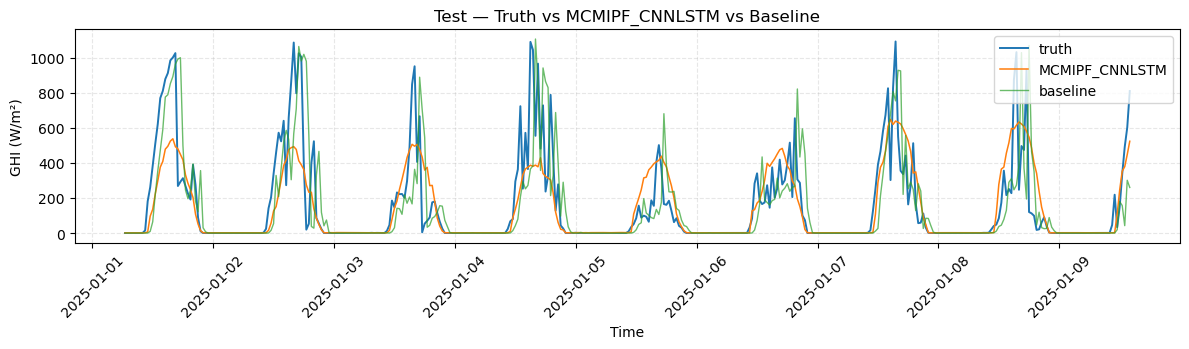

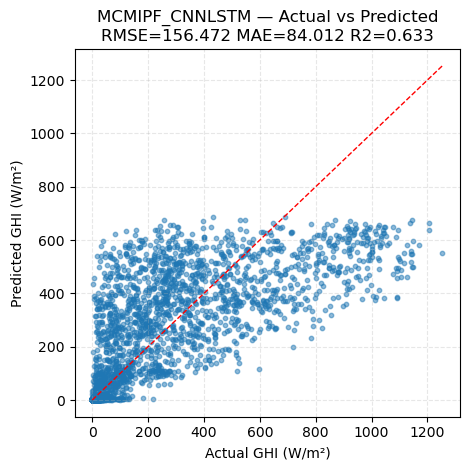

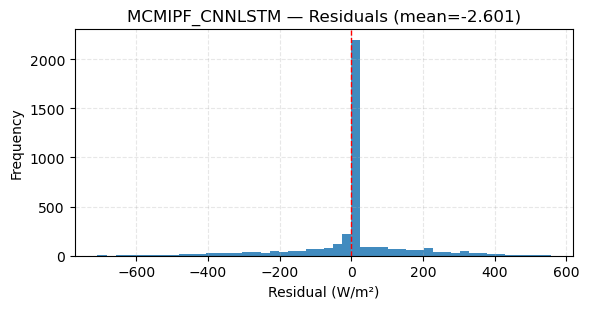

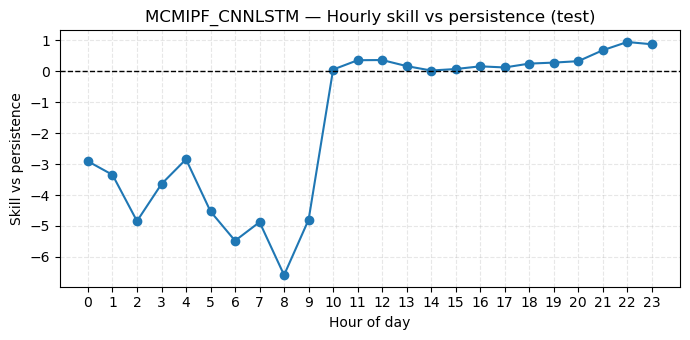

PosixPath('/mnt/SOLARLAB/E_Ladino/Repo/irradiance-fusion-forecast/outputs_mcmipf_ground/figures/MCMIPF_CNNLSTM_hourly_skill.png')

In [11]:
es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)

H, W, C = Xtr_img_seq.shape[2:]
model_img = build_mcmipf_cnn_lstm_model(L=SEQ_LEN, H=H, W=W, C=C)
print(model_img.summary())

hist_img = model_img.fit(
    Xtr_img_seq, ytr_img,
    validation_data=(Xva_img_seq, yva_img),
    epochs=MAX_EPOCHS,
    batch_size=8,
    verbose=1,
    callbacks=[es],
    shuffle=True
)

yhat_img = model_img.predict(Xte_img_seq, verbose=0).squeeze()

rmse_img  = _rmse(yte_img, yhat_img)
mae_img   = mean_absolute_error(yte_img, yhat_img)
r2_img    = r2_score(yte_img, yhat_img)
skill_img = skill(yte_img, yhat_img, y_base_seq_img)

print("\n=== MCMIPF image-only (CNN-LSTM) — Test metrics ===")
print(f"RMSE={rmse_img:.4f} | MAE={mae_img:.4f} | R2={r2_img:.4f} | Skill={skill_img:.3f}")

plot_ts_clip(idx_te_img, yte_img, yhat_img, y_base_seq_img, "MCMIPF_CNNLSTM", FIG_DIR)
plot_scatter(yte_img, yhat_img, "MCMIPF_CNNLSTM", FIG_DIR)
plot_residuals(yte_img, yhat_img, "MCMIPF_CNNLSTM", FIG_DIR)

sk_df_img = hourly_skill_df(yte_img, yhat_img, y_base_seq_img, idx_te_img)
plot_hourly_skill(sk_df_img, "MCMIPF_CNNLSTM", FIG_DIR)

### MCMIPF + Tabular Fusion

Model: "MCMIPF_Tabular_Fusion_ground"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_seq             │ (None, 6, 32, 32, │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_mcm_cnn          │ (None, 6, 64)     │    102,688 │ img_seq[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tab_seq             │ (None, 6, 45)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_img (LSTM)     │ (None, 64)        │     33,024 │ td_mcm_cnn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_tab (LSTM)     │ (None, 64)        │     28,160 │ tab_seq[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_concat       │ (None, 128)       │          0 │ lstm_img[0][0],   │
│ (Concatenate)       │                   │            │ lstm_tab[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dense        │ (None, 64)        │      8,256 │ fusion_concat[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dropout      │ (None, 64)        │          0 │ fusion_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y_hat (Dense)       │ (None, 1)         │         65 │ fusion_dropout[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 172,193 (672.63 KB)

 Trainable params: 171,745 (670.88 KB)

 Non-trainable params: 448 (1.75 KB)

None
Epoch 1/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 32263.6895 - val_loss: 19037.5508
Epoch 2/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 19244.7031 - val_loss: 18046.4375
Epoch 3/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 18103.9570 - val_loss: 17489.2891
Epoch 4/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 17637.1465 - val_loss: 17753.6406
Epoch 5/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 17521.7148 - val_loss: 17542.7715
Epoch 6/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 16905.8672 - val_loss: 17762.8320
Epoch 7/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 16706.1797 - val_loss: 17645.3984
Epoch 8/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 16264.7832 - val_loss: 17876.8965
Epoch 9/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 16099.3545 - val_loss: 18454.7051
Epoch 10/25
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 15707.9873 - val_loss: 18296.7285
Epoch 10: early stopping

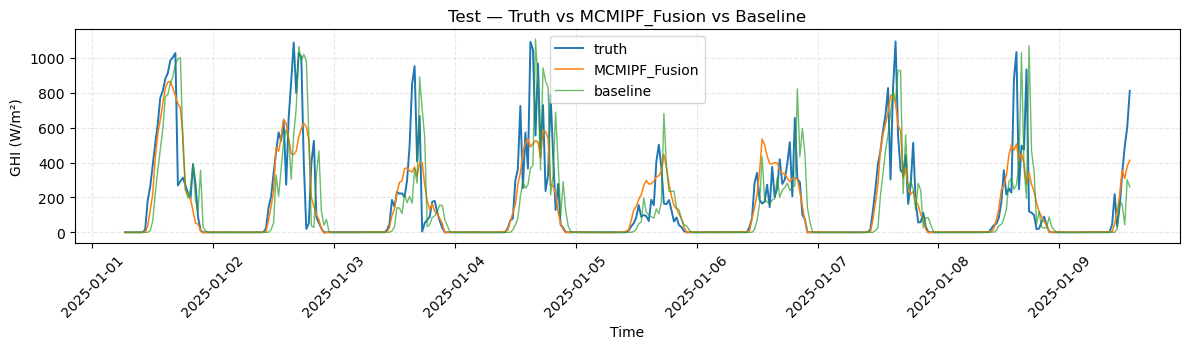

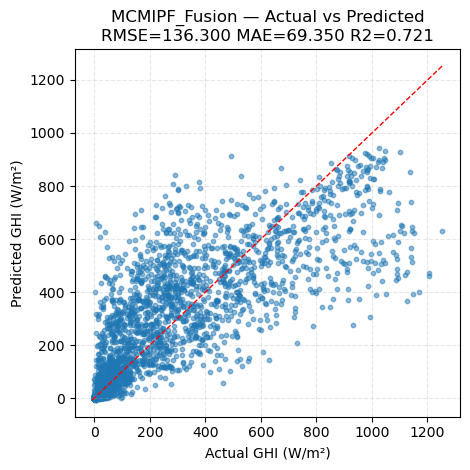

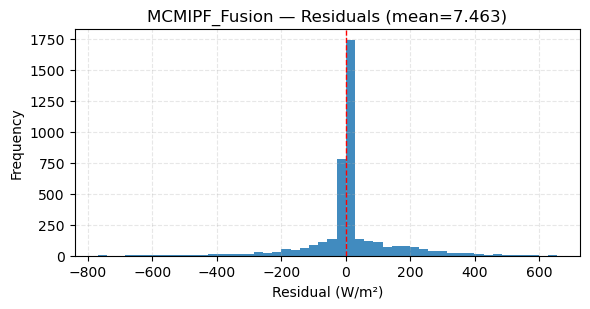

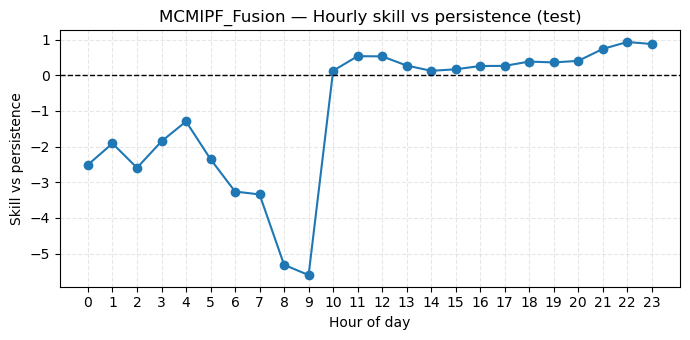

PosixPath('/mnt/SOLARLAB/E_Ladino/Repo/irradiance-fusion-forecast/outputs_mcmipf_ground/figures/MCMIPF_Fusion_hourly_skill.png')

In [12]:
tab_dim = Xtr.shape[1]
model_fus = build_mcmipf_tabular_fusion_model(
    L=SEQ_LEN,
    tab_dim=tab_dim,
    H=H, W=W, C=C
)
print(model_fus.summary())

es_fus = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=PATIENCE + 2,
    restore_best_weights=True,
    verbose=1
)

hist_fus = model_fus.fit(
    {"img_seq": Xtr_imgf, "tab_seq": Xtr_tabf},
    ytr_f,
    validation_data=(
        {"img_seq": Xva_imgf, "tab_seq": Xva_tabf},
        yva_f
    ),
    epochs=MAX_EPOCHS,
    batch_size=8,
    verbose=1,
    callbacks=[es_fus],
    shuffle=True
)

yhat_fus = model_fus.predict(
    {"img_seq": Xte_imgf, "tab_seq": Xte_tabf},
    verbose=0
).squeeze()

rmse_fus  = _rmse(yte_f, yhat_fus)
mae_fus   = mean_absolute_error(yte_f, yhat_fus)
r2_fus    = r2_score(yte_f, yhat_fus)
skill_fus = skill(yte_f, yhat_fus, y_base_seq_fus)

print("\n=== MCMIPF + Tabular Fusion — Test metrics ===")
print(f"RMSE={rmse_fus:.4f} | MAE={mae_fus:.4f} | R2={r2_fus:.4f} | Skill={skill_fus:.3f}")

plot_ts_clip(idx_te_f, yte_f, yhat_fus, y_base_seq_fus, "MCMIPF_Fusion", FIG_DIR)
plot_scatter(yte_f, yhat_fus, "MCMIPF_Fusion", FIG_DIR)
plot_residuals(yte_f, yhat_fus, "MCMIPF_Fusion", FIG_DIR)

sk_df_fus = hourly_skill_df(yte_f, yhat_fus, y_base_seq_fus, idx_te_f)
plot_hourly_skill(sk_df_fus, "MCMIPF_Fusion", FIG_DIR)

## Summary

In [13]:
summary = pd.DataFrame({
    "MCMIPF_CNNLSTM": {
        "RMSE": rmse_img,
        "MAE": mae_img,
        "R2":  r2_img,
        "Skill": skill_img,
    },
    "MCMIPF_Fusion": {
        "RMSE": rmse_fus,
        "MAE": mae_fus,
        "R2":  r2_fus,
        "Skill": skill_fus,
    }
}).T

print("\n=== Summary (MCMIPF models, test set) ===")
print(summary.round(4).to_string())

summary.to_csv(OUT_DIR / "mcmipf_models_test_metrics.csv", index=True)


=== Summary (MCMIPF models, test set) ===
                   RMSE      MAE      R2   Skill
MCMIPF_CNNLSTM  156.472  84.0118  0.6328  0.2069
MCMIPF_Fusion   136.300  69.3504  0.7214  0.3091
